# Titanic Challenge from Kaggle

## 1. Introduction

<div style="text-align: justify">The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, **killing 1502 out of 2224 passengers and crew**. This sensational tragedy shocked the international community and led to better safety regulations for ships.</div>

<div style="text-align: justify">One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as *women, children, and the upper-class.*</div>

<div style="text-align: justify">In this challenge, I try to complete the analysis of what sorts of people were likely to survive applying **machine learning** tools to predict which passengers survived the tragedy.</div>

#### Import libraries

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline

from collections import Counter


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

## 2. Load and check data

#### 2.1 Load data

In [2]:
##### Load train and Test set

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The **Survived** feature is the target variable. If the passenger survived, then *Survived* = 1. Otherwise, he or she died.

#### Data dictionary:
    - survival     Survival 	            0 = No, 1 = Yes
    - pclass       Ticket class 	        1 = 1st, 2 = 2nd, 3 = 3rd
    - sex          Sex 	
    - Age          Age in years 	
    - sibsp 	   # of siblings / spouses aboard the Titanic 	
    - parch 	   # of parents / children aboard the Titanic 	
    - ticket       Ticket number 	
    - fare         Passenger fare 	
    - cabin        Cabin number 	
    - embarked     Port of Embarkation      C = Cherbourg, Q = Queenstown, S = Southampton

#### Variable Notes:
**pclass**: A proxy for socio-economic status (SES)<br />
1st = Upper<br />
2nd = Middle<br />
3rd = Lower<br />

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way:<br />
*Sibling* = brother, sister, stepbrother, stepsister<br />
*Spouse* = husband, wife (mistresses and fiancés were ignored)<br />

**parch**: The dataset defines family relations in this way:<br />
*Parent* = mother, father<br />
*Child* = daughter, son, stepdaughter, stepson<br />
Some children travelled only with a nanny, therefore parch=0 for them.

#### 2.2 Outlier detection

In [4]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [5]:
# detect outliers from digital features 
outliers_to_drop = detect_outliers(train,2,["Pclass","Age","SibSp","Parch","Fare"])

In [6]:
train.loc[outliers_to_drop] # No outliers in Pclass, Age or Parch

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


We detect *10 outliers*. The 28, 89 and 342 passenger have an high Ticket Fare. The 7 others have very high values of SibSP. Considering n=1, there would be 81 outliers.

In [7]:
len(detect_outliers(train,1,["Pclass","Age","SibSp","Parch","Fare"]))

81

In [8]:
# Drop outliers
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

#### 2.3 Joining train and test set

In [9]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
dataset =  pd.concat(objs=[train, test], axis=0).reset_index().drop('index',axis=1)

#### 2.4 Check for missing values

In [10]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values in dataset
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [11]:
#Check for Null values in train
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [12]:
#Feature data types
dataset.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived       float64
Ticket          object
dtype: object

In [13]:
#Summarize train dataset
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature Analysis

#### 3.1 Numerical Values

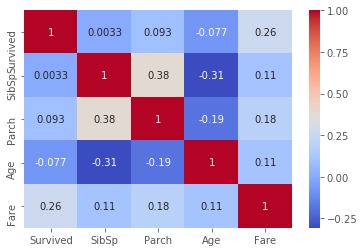

In [14]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, cmap = "coolwarm")

#### SibSp

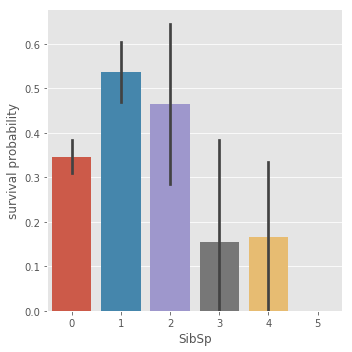

In [15]:
# Explore SibSp feature vs Survived
sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar",size = 5).set_ylabels("survival probability")

It seems that passengers having a lot of siblings/spouses have less chance to survive. Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive. We can consider a new feature describing these categories.

#### Parch

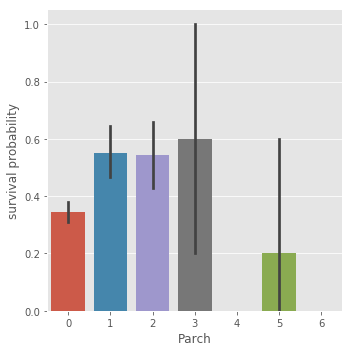

In [16]:
# Explore Parch feature vs Survived
sns.factorplot(x="Parch",y="Survived",data=train,kind="bar",size = 5).set_ylabels("survival probability")

#### Age

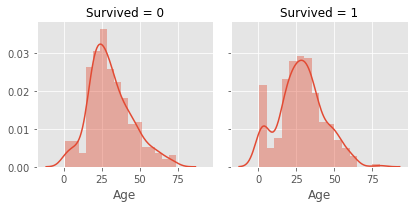

In [17]:
# Explore Age vs Survived
sns.FacetGrid(train, col='Survived').map(sns.distplot, "Age")

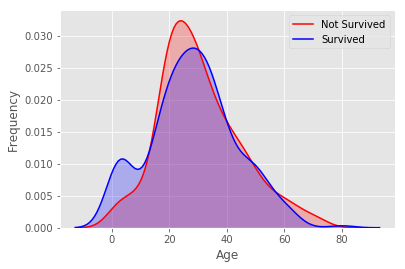

In [18]:
# Explore Age distibution 
g=sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red",shade = True)
g=sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=g, color="Blue",shade = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g.legend(["Not Survived","Survived"])

So, even if **Age** is not correlated with "Survived", we can see that there is age categories of passengers that of have more or less chance to survive. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.

#### Fare

Since we have one missing value, we are going to fill it with the median value which will not have an important effect on the prediction.

In [19]:
dataset['Fare'].isnull().sum()

1

In [20]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

Not Survived Skew: 4.672917006976249
Survived Skew: 4.077138539816583


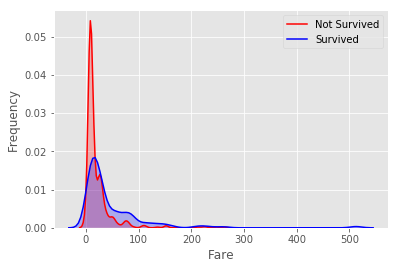

In [21]:
# Explore Fare distibution 
g = sns.kdeplot(train["Fare"][train["Survived"] == 0], color="Red", shade = True)
g = sns.kdeplot(train["Fare"][train["Survived"] == 1], ax =g, color="Blue", shade= True)
g.set_xlabel("Fare")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])
print('Not Survived Skew: {}'.format(train["Fare"][train["Survived"] == 0].skew()))
print('Survived Skew: {}'.format(train["Fare"][train["Survived"] == 1].skew()))

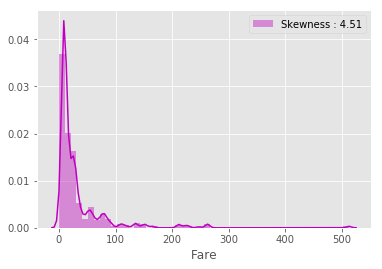

In [22]:
# Explore Fare distribution 
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend()

Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled. In this case, it is better to transform it with the log function to reduce this skew.

In [23]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

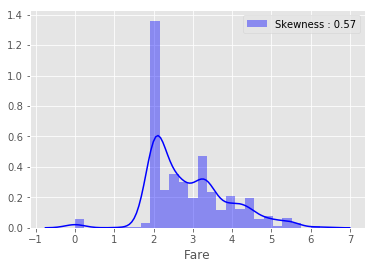

In [24]:
sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew())).legend()

#### 3.2 Categorical Values

#### Sex

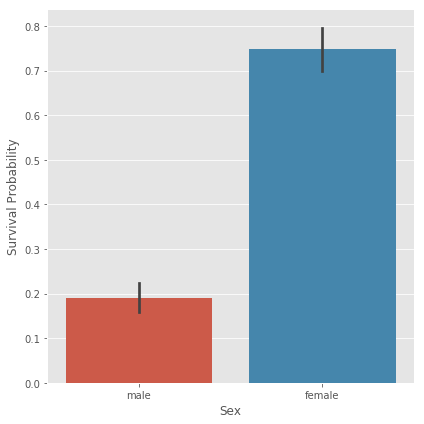

In [25]:
sns.factorplot(x="Sex",y="Survived",data=train,kind="bar",size=6).set_ylabels("Survival Probability")

Male have less chance to survive than Female. So **Sex**, might play an important role in the prediction of the survival

In [26]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

#### Pclass

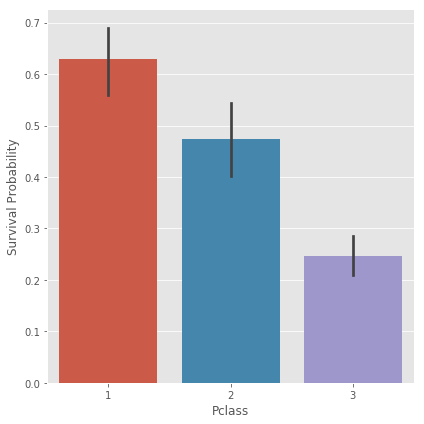

In [27]:
sns.factorplot(x="Pclass",y="Survived",data=train,kind="bar",size=6).set_ylabels("Survival Probability")

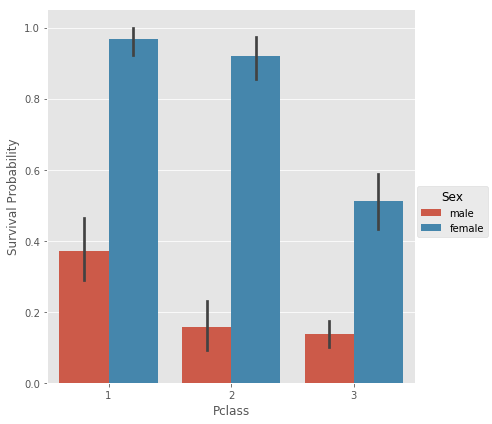

In [28]:
sns.factorplot(x="Pclass",y="Survived",hue="Sex",data=train,kind="bar",size=6).set_ylabels("Survival Probability")

The passenger survival is not the same in the 3 classes. First and Second class passengers have more chance to survive in female passengers and First class passengers have more chance to survive in male passengers.

#### Embarked

We have two missing values in this feature, so we are going to fill them with the most fequent value of "Embarked" (S).

In [29]:
dataset['Embarked'].isnull().sum()

2

In [30]:
dataset["Embarked"].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [31]:
dataset['Embarked'] = dataset['Embarked'].fillna("S")

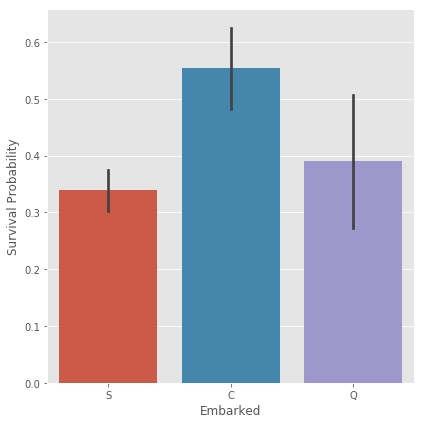

In [32]:
sns.factorplot(x="Embarked",y="Survived",data=train,kind="bar",size=6).set_ylabels("Survival Probability")

It seems that passenger coming from Cherbourg (C) have more chance to survive. Let's see the Pclass distribution vs Embarked in order to check if there is a correlation between this two variables.

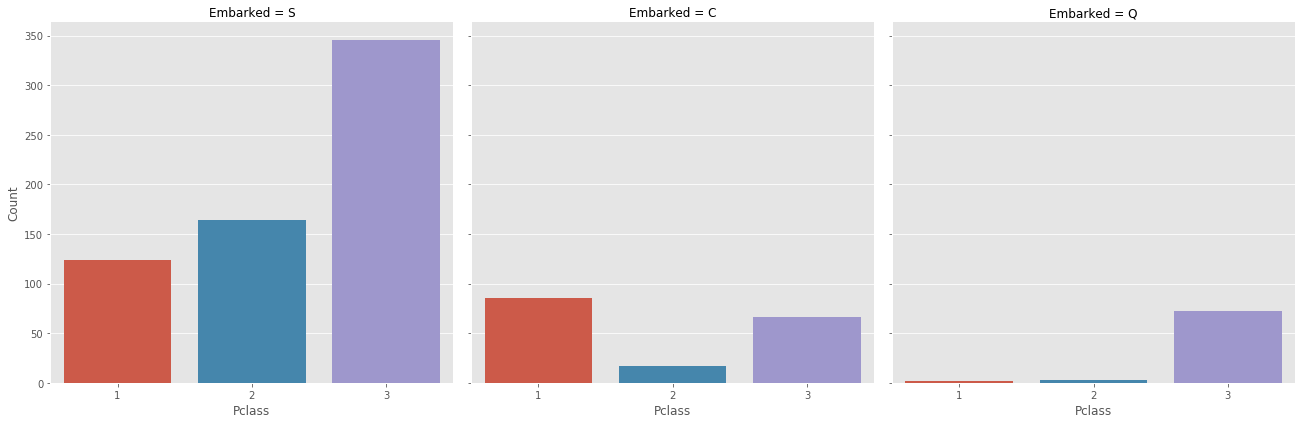

In [33]:
sns.factorplot(x="Pclass",col="Embarked",data=train,kind="count",size=6).set_ylabels("Count")

The third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

## 4. Filling missing values

#### Age

As we saw earlier, Age column contains 256 missing values in the whole dataset. 

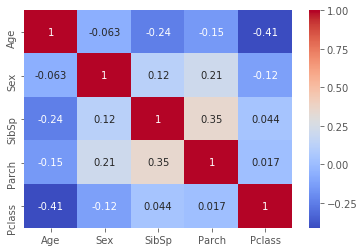

In [34]:
sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="coolwarm",annot=True)

Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.

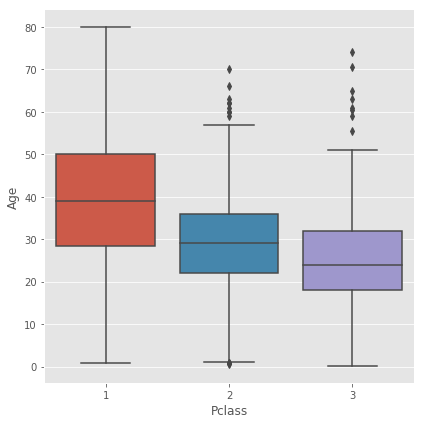

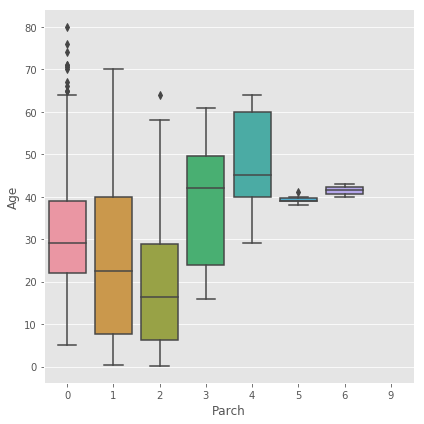

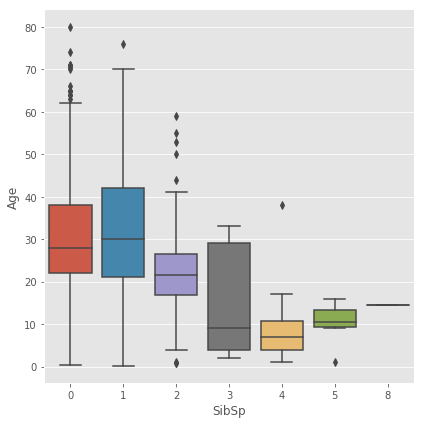

In [35]:
sns.factorplot(y="Age",x="Pclass",data=dataset,kind="box",size=6)
sns.factorplot(y="Age",x="Parch",data=dataset,kind="box",size=6)
sns.factorplot(y="Age",x="SibSp",data=dataset,kind="box",size=6)

We are going to fill **Age** with the median of similar rows according to **Pclass**, **Parch** and **SibSp**.

In [36]:
#Save median of similar Pclass, Parch and SibSp rows
dict_age = dict(dataset.groupby(['Pclass','Parch','SibSp']).agg(['median'])['Age']['median'])

#Apply dictionary to misssing ages
fill_age = dataset.apply(lambda x:dict_age[tuple(x[['Pclass','Parch','SibSp']])] 
                         if np.isnan(x['Age']) else x['Age'], axis=1)

dataset['Age'] = fill_age

In [37]:
dataset['Age'].isnull().sum()

2

In [38]:
#Missing values that don't belong to any previous group are replaced by median of ages.
dataset['Age'][np.isnan(dataset['Age'])]=dataset['Age'].median()

## 5. Feature Engineering

#### 5.1 Title from Name

In [39]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name feature contains information on passenger's title. Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.

In [40]:
dataset['Title']=pd.Series(map(lambda x:x.split(',')[1].split('.')[0].strip(),dataset['Name']))
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

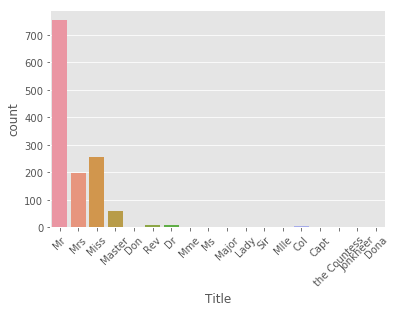

In [41]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

There is 17 titles in the dataset, some of them are very rare and we can group them in 4 categories: *Mr, Miss/Ms/Mme/Mlle/Mrs, Master* and *Rare*.

In [42]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Don','Rev','Dr','Mme','Ms','Ms','Major','Lady','Sir','Mlle',
                                            'Col','Capt','the Countess','Jonkheer','Dona'], 'Rare')

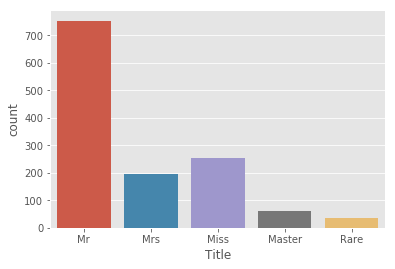

In [43]:
sns.countplot(dataset["Title"])

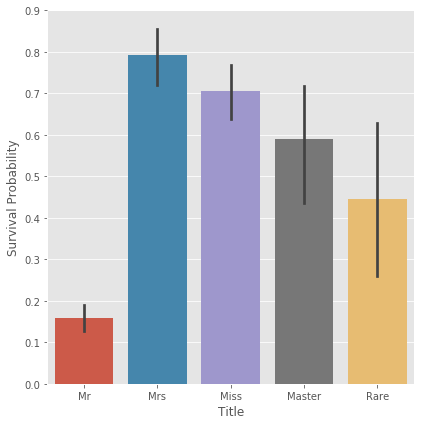

In [44]:
sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar",size=6).set_ylabels("Survival Probability")

In [45]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

#### 5.2 Family Size

We are going to create a **FamilySize** feature which is the sum of SibSp , Parch and 1 (including the passenger).

In [46]:
# Create a family size descriptor from SibSp and Parch
dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1

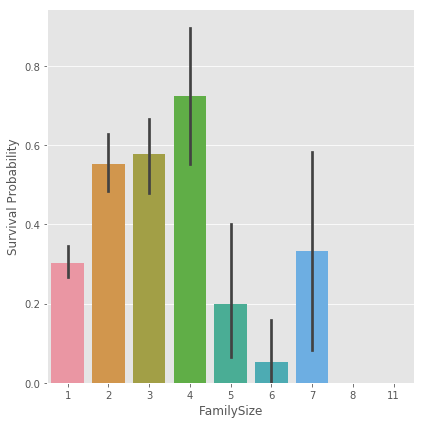

In [47]:
sns.factorplot(x="FamilySize",y="Survived",data=dataset,kind="bar",size=6).set_ylabels("Survival Probability")

In [48]:
# Create new feature of family size
dataset['Single'] = dataset['FamilySize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallFam'] = dataset['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedFam'] = dataset['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeFam'] = dataset['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

In [49]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"])

In [50]:
dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,MedFam,LargeFam,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_C,Embarked_Q,Embarked_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,0,0,0,0,1,0,0,0,0,1
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,0,0,0,0,0,1,0,1,0,0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,1,0,0,0,0,0,1
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,0,0,0,0,0,1,0,0,0,1
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0,1,0,0,0,0,1


#### 5.3 Cabin

In [51]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [52]:
dataset["Cabin"].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

The Cabin feature column contains 292 values and 1007 missing values. We are going to keep the first letter of the cabin, since it may indicate the location of the passenger in the Titanic.

In [53]:
dataset["Cabin"] = dataset['Cabin'].map(lambda x:x[0] if not pd.isnull(x) else 'U')

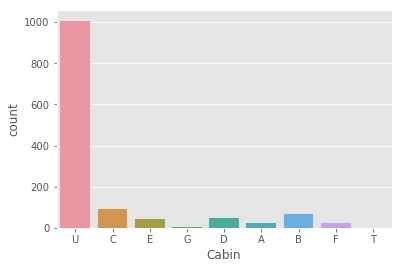

In [54]:
sns.countplot(dataset["Cabin"])

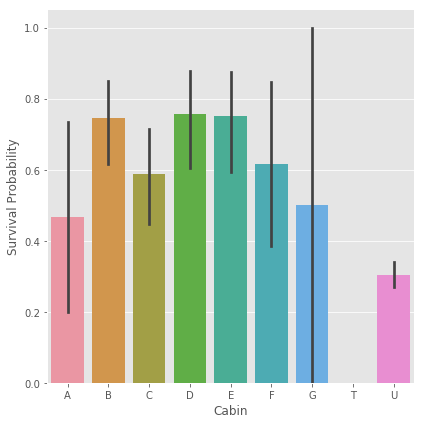

In [55]:
sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",
               order=['A','B','C','D','E','F','G','T','U'],size=6).set_ylabels("Survival Probability")

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation. But we can see that passengers with a cabin have generally more chance to survive than passengers with unknown one (*U*).

In [56]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"])

#### 5.4 Ticket

In [57]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It seems that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship. We are going to replace the Ticket feature column by the ticket prefixe.

In [58]:
dataset['Ticket'] = dataset['Ticket'].map(lambda x:x.replace('.','').replace('/','').strip().split()[0] if not x.isdigit() else 'Digit')

In [59]:
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3     Digit
4     Digit
Name: Ticket, dtype: object

In [60]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="Ticket")

#### 5.5 Final Dataset

In [61]:
#Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [62]:
#Get dummies values for Pclass
dataset = pd.get_dummies(dataset, columns = ["Pclass"])

In [63]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,FamilySize,Single,SmallFam,MedFam,...,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Pclass_1,Pclass_2,Pclass_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## 6. Modeling

#### 6.1 Splitting dataset in train and test sets

In [64]:
train = dataset[pd.isnull(dataset['Survived'])==False]
test = dataset[pd.isnull(dataset['Survived'])]

In [65]:
#Separate train features and label
y_train = train['Survived'].astype(int)
X_train = train.drop('Survived',axis=1)

X_test = test.drop('Survived',axis=1)

#### 6.2 Simple modeling

##### 6.2.1 Cross Validate models

We are going to compare 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.
- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis


In [66]:
#Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [67]:
#Modeling step Test differents algorithms 
random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [68]:
#Accuracy for each fold
cv_results = []

for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

In [69]:
#Mean and standard deviation accuracy of each classifier
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [70]:
#Saving results in cv_res
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees",
                                    "GradientBoosting","MultipleLayerPerceptron","KNeighboors",
                                    "LogisticRegression","LinearDiscriminantAnalysis"]})

In [71]:
cv_res.sort_values(['CrossValMeans'],ascending=False)

,Algorithm,CrossValMeans,CrossValerrors
6,MultipleLayerPerceptron,0.830886,0.029749
5,GradientBoosting,0.826341,0.043993
0,SVC,0.825217,0.043690
8,LogisticRegression,0.825204,0.035248
9,LinearDiscriminantAnalysis,0.822932,0.035986
2,AdaBoost,0.807150,0.057588
1,DecisionTree,0.799170,0.038831
3,RandomForest,0.797970,0.041773
4,ExtraTrees,0.795748,0.042439
7,KNeighboors,0.780963,0.040148


In [72]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= , verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.6min finished


0.83314415437003408

In [73]:
y_test=gsRFC.predict(X_test)

In [74]:
output=pd.DataFrame({'PassengerId':pd.read_csv('./data/test.csv')['PassengerId'],
                     'Survived':y_test})
output.to_csv('./models/output.csv',index=False)